# QUAIL Pipeline
**Quick-RAIL, A Simplified RAIL Degradation Pipeline**

This pipeline heavily references the pipeline created in RAIL's Degradation Demo notebook, which can be found [rendered on ReadTheDocs](https://rail-hub.readthedocs.io/projects/rail-notebooks/en/latest/rendered/creation_examples/degradation-demo.html) and in [notebook form on GitHub](https://github.com/LSSTDESC/rail/blob/main/examples/creation_examples/degradation-demo.ipynb).

## Welcome!

The recommended order of action is as follows: 

_(However, because the pipeline is already able to run as-is, you are free to skip any steps and come back to them later.)_

1. Read through the whole notebook.
1. Implement an Incorrectness stage.
    1. Each row will have some change of its redshift value being changed to a random value.
    1. This kind of degrader is especially useful in cases where you need a pipeline to test for the impact of incorrect values in your training set, and how it will impact your estimations on your test set. In essense, how sensitive is your estimator to bad values in your training set? If even a tenth of a percent of values being bad will ruin things, that's good to know up front!
1. Implement InvRedshiftIncompleteness.
    1. This degrader applies a selection function, which keeps galaxies with probability $p_{\text{keep}}(z) = \min(1, \frac{z_p}{z})$, where $z_p$ is the ''pivot'' redshift. We'll use $z_p = 0.8$.
    1. If this speaks to you, consider other incompleteness degrader stages you could implement. Different survival functions can be applied to different bands (see [Malmquist bias](https://en.wikipedia.org/wiki/Malmquist_bias)), and this will result in different redshift distributions. 
    1. We recommend using scipy's [continuous distributions](https://docs.scipy.org/doc/scipy/reference/stats.html#continuous-distributions), which have survival functions as a method called `sf` (eg, see [alpha.sf docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.alpha.html#scipy.stats.alpha:~:text=sf(x%2C%20a%2C%20loc%3D0%2C%20scale%3D1))).
1. Once you have at least a couple degraders to choose from, take some time to play around with the pipeline and see how different adding and removing degraders in different combinations will affect the results.
1. Implement LSSTErrorModel to replace the BadErrorModel.
    1. More info on how the error model is generated is in the LSST docs.
    2. If you'd like a hint, we recommend looking at John Franklin's code in his implementation of the LSSTErrorModel ([repo here](https://github.com/jfcrenshaw/photerr/tree/main/photerr)).
1. Implement better plotting functionality (as described at the end).


## Setting things up

Start by making a conda environment (or translate these instructions for your preferred environment manager):

`conda create -n quail python=3.10`

Install the following packages:
```
pip install pzflow
pip install pz-rail-pzflow
pip install matplotlib
pip install ipykernel
```

Make your conda environment available as a kernel for your notebook:

`python -m ipykernel install --user --name quail`

In [7]:
# %pip install pzflow
# %pip install pz-rail-pzflow
# %pip install matplotlib
# %pip install ipykernel

In [8]:
# %pip install jaxlib  # Specify an older version that is known to work without AVX

In [1]:
# Then our imports:
from numbers import Number
import os
import pandas as pd

#import pzflow
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Generate our truth data from PZFlow

In [2]:
flow_file = pd.read_pickle('samples_truth.pkl')
flow_file

,redshift,u,g,r,i,z,y
0,0.890625,27.370831,26.712662,26.025227,25.327188,25.016504,24.926823
1,1.978239,29.557047,28.361183,27.587229,27.238544,26.628109,26.248562
2,0.974287,26.566011,25.937712,24.787411,23.872452,23.139565,22.832047
3,1.317978,29.042734,28.274597,27.501108,26.648792,26.091450,25.346502
4,1.386366,26.292625,25.774780,25.429962,24.806532,24.367950,23.700010
...,...,...,...,...,...,...,...
99995,2.147171,26.550978,26.349936,26.135284,26.082018,25.911028,25.558134
99996,1.457508,27.362207,27.036274,26.823139,26.420128,26.110035,25.524902
99997,1.372993,27.736044,27.271955,26.887581,26.416138,26.043434,25.456161
99998,0.855022,28.044552,27.327118,26.599014,25.862333,25.592169,25.506388


In [3]:
# flow_file = os.path.join(
#     os.path.dirname(pzflow.__file__), "example_files", "example-flow.pzflow.pkl"
# )
# flowCreator_truth = pzflow.Flow(file=flow_file)

n_samples = int(1e5)
samples_truth = flow_file.sample(n_samples)

In [4]:
samples_truth

,redshift,u,g,r,i,z,y
55606,0.274375,22.575424,20.562437,19.182606,18.655003,18.376507,18.144571
5492,0.609481,26.177778,25.768097,24.972853,24.450748,24.322546,24.172985
32076,0.357505,26.635614,26.297935,25.728689,25.646473,25.348820,25.431658
38253,0.771426,23.617403,23.551189,22.874117,21.907862,21.351149,21.087290
81163,0.790994,25.601871,25.317299,24.798958,24.087276,23.867321,23.798540
...,...,...,...,...,...,...,...
92285,0.998469,26.757711,26.442570,25.967600,25.513737,25.060711,24.937050
61831,0.854946,26.664486,25.918753,24.527800,23.359274,22.738544,22.522497
18197,2.199502,27.139866,26.942619,26.740353,26.718845,26.611641,26.358942
40621,1.502140,26.802992,26.545099,26.354998,26.016073,25.796749,25.282021


## QUAIL Base Classes

We'll be using a few highly simplified versions of RAIL classes, namely:
- QuailStage (accompanied by a NothingStage, to demonstrate how we'll inherit for our other degrader stages)
- DataStore
- Pipeline

In [10]:
from abc import ABC, abstractmethod
import numpy as np

class QuailStage(ABC):
    """A class for the QuailStage stage."""

    def __init__(self, name):
        """Constructor.
        
        Parameters
        ----------
        name : str
            The (human-readable) name of the stage (this will be used in the Pipeline's __repr__).
        """
        self.name = name
        self.data_in = None
        self.data_out = None

    @abstractmethod
    def run(self):
        """To be implemented in subclasses. This should set the data_out attribute."""
        pass

In [7]:
class NothingStage(QuailStage):
    """A stage that does nothing."""
    def __init__(self, name):
        """Constructor.
        
        Parameters
        ----------
        name : str
            The name of the stage.
        """
        super().__init__(name)

    def run(self):
        """Run the stage."""
        self.data_out = self.data_in

## Degrader 1: BadErrorModel

We start by creating an incredibly naive error model as a stand-in for the LSSTErrorModel.

This will generate u_err, g_err, etc. columns for us, but there's no scientific basis for the values it generates.

In [8]:
class BadErrorModel(QuailStage):
    """A stage that applies bad errors."""
    def __init__(self, name):
        """Constructor.
        
        Parameters
        ----------
        name : str
            The name of the stage.
        """
        super().__init__(name)

    def apply_errors(self):
        """Apply the errors to the input data.
        
        Returns
        -------
        errors : pandas.DataFrame
            The input data with errors applied.
        """
        # create a copy of the input data
        errors = self.data_in.copy()
        for col in ["u", "g", "r", "i", "z", "y"]:
            # create a new column with the error
            errors[f"{col}_err"] = 0.01 * self.data_in[col]
        # reorder the columns
        errors = errors[["redshift", "u", "u_err", "g", "g_err", "r", "r_err", "i", "i_err", "z", "z_err", "y", "y_err"]]
        return errors

    def run(self):
        """Run the stage."""
        self.data_out = self.apply_errors()

    def plot(self):
        """Plot the truth data and the errors."""
        if self.data_out is None:
            raise ValueError("You must run the stage first.")
        
        fig, ax = plt.subplots(figsize=(5, 4), dpi=100)

        for band in "ugrizy":
            # pull out the magnitudes and errors
            mags = self.data_out[band].to_numpy()
            errs = self.data_out[band + "_err"].to_numpy()

            # sort them by magnitude
            mags, errs = mags[mags.argsort()], errs[mags.argsort()]

            # plot errs vs mags
            ax.plot(mags, errs, label=band)

        ax.legend()
        ax.set(xlabel="Magnitude (AB)", ylabel="Error (mags)")
        plt.show()

## Degrader 2: QuantityCut

This degrader is based on our QuantityCut example in the degradation demo notebook.

In [9]:
class QuantityCut(QuailStage):
    """Applies a cut to the input data based on a quantity.
    
    Parameters
    ----------
    name : str
        The name of the stage.
    cuts : dict
        A dictionary of cuts to apply to the data. 

    Notes
    -----
    The cut keys should be the names of columns you wish to make cuts on.

    The cut values should be either:
    - a number, which is the maximum value. E.g. if the dictionary
    contains "i": 25, then values of i > 25 are cut from the sample.
    - an iterable, which is the range of acceptable values. E.g. if the 
    dictionary contains "redshift": (1.5, 2.3), then redshifts outside that
    range are cut from the sample.
    """
    def __init__(self, name="QuantityCut", cuts=None):
        """Constructor.
        """
        super().__init__(name=name)
        self.cuts = cuts 
        self.data_out = None

    def apply_cut(self):
        """Apply the cuts to the input data.
        
        Returns
        -------
        data_out : pandas.DataFrame
            The input data with the cut applied.
        """
        # create a copy of the input data
        data_out = self.data_in.copy()
        
        # Apply the cuts
        for col, cut in self.cuts.items():
            if isinstance(cut, Number):
                # Apply cut as maximum value
                data_out = data_out[data_out[col] <= cut]
            elif hasattr(cut, "__iter__"):
                # Apply cut as range of acceptable values
                data_out = data_out[(data_out[col] >= cut[0]) & (data_out[col] <= cut[1])]
            else:
                raise TypeError("Cut must be a number or an iterable of (min, max)")

        return data_out

    def run(self):
        """Run the stage."""
        data_out = self.apply_cut()
        self.data_out = data_out

## Degrader 3: InvRedshiftIncompleteness

This one is up to you! Feel free to reference 

In [27]:
# Potentially, write an InvRedshiftIncompleteness for them here

class InvRedshiftIncompleteness(QuailStage):
    """A function that applies and incomplete inverse redshift. 
    This degrader applies a selection function, which keeps galaxies 
    with probability $p_{\text{keep}}(z) = \min(1, \frac{z_p}{z})$, 
    where $z_p$ is the ''pivot'' redshift. We'll use $z_p = 0.8$
    """
    
    def __init__(self, name, z_p=0.8):
        """
        Constructor.
        
        Parameters
        ----------
        name : str
            The name of the stage.
        z_p : float
            The pivot redshift. Default value is 0.8
        """
        super().__init__(name)
        self.z_p = z_p
        
    def run(self):
        """Run the stage."""
        if self.data_in is None:
            raise ValueError("You must run the stage first.")
        # Add the data into an array
        z = np.array(self.data_in["redshift"])
        
        # Calculating the probability of the selection fn
        p_keep = np.minimum(1, self.z_p / z)
        
        # Generate random values for each galaxy
        vals = np.random.rand(len(z))
        
        # Select galaxies based on probability
        mask = vals < p_keep
        
        # Set the data_out to be the masked z values
        self.data_out = z[mask]

In [26]:
#print(z.shape)

NameError: name 'z' is not defined

## Making the Pipeline

In [28]:
class DataStore(dict):
    def __init__(self):
        dict.__init__(self)
    
    def __getattr__(self, key): # Code copied from RAIL's DataStore 
        """Allow attribute-like parameter access"""
        try:
            return self.__getitem__(key)
        except KeyError as msg:
            # Kludge to get docstrings to work
            if key in ["__objclass__"]:  # pragma: no cover
                return None
            raise KeyError from msg
    
    def __repr__(self): # Feel free to change this output into whatever you like!
        """Prints the DataStore keys and shapes in a human-readable format."""
        s = "DataStore\n"
        for key in self.keys():
            s += f"  {key}:\n\t{self[key].shape}\n"
        return s
    


In [29]:
class Pipeline:
    def __init__(self, data_store, stages):
        self.data_store = data_store
        self.stages = stages

    def run(self):
        current_data = self.data_store["input_data"]
        for stage in self.stages:
            print(f"Running stage: {stage.name}")
            stage.data_in = current_data
            stage.run()
            self.data_store[f"{stage.name}_data"] = stage.data_out
            current_data = stage.data_out
        self.data_store["output_data"] = current_data

    def __repr__(self):
        s = "Pipeline\n"
        for stage in self.stages:
            s += f"  {stage.name}\n"
        return s
    
    def get_stage(self, stage_name):
        for stage in self.stages:
            if stage.name == stage_name:
                return stage
        print(f"Stage {stage_name} not found in pipeline.")
        return None

    def plot(self):
        pass

    def save(self):
        pass


In [30]:
DS = DataStore()
DS["input_data"] = samples_truth

stages = [
    NothingStage("do_nothing"),
    BadErrorModel("bad_error_model"),
    QuantityCut("quality_cut", cuts={"i": 25.3}),
    InvRedshiftIncompleteness("incomplete_inv_z", z_p=0.8),
]

pipeline = Pipeline(DS, stages)

In [31]:
# Our DataStore before running the pipeline

DS

DataStore
  input_data:
	(100000, 7)

In [32]:
pipeline.run()

Running stage: do_nothing
Running stage: bad_error_model
Running stage: quality_cut
Running stage: incomplete_inv_z


In [14]:
# Our DataStore after running the pipeline

DS

DataStore
  input_data:
	(100000, 7)
  do_nothing_data:
	(100000, 7)
  bad_error_model_data:
	(100000, 13)
  quality_cut_data:
	(51834, 13)
  output_data:
	(51834, 13)

## Looking at the data

Poke around and see the changes you've made! Note that overloading the `__getattr__` in our DataStore class lets us access data via `DS.key` syntax.

In [33]:
DS.quality_cut_data

,redshift,u,u_err,g,g_err,r,r_err,i,i_err,z,z_err,y,y_err
55606,0.274375,22.575424,0.225754,20.562437,0.205624,19.182606,0.191826,18.655003,0.186550,18.376507,0.183765,18.144571,0.181446
5492,0.609481,26.177778,0.261778,25.768097,0.257681,24.972853,0.249729,24.450748,0.244507,24.322546,0.243225,24.172985,0.241730
38253,0.771426,23.617403,0.236174,23.551189,0.235512,22.874117,0.228741,21.907862,0.219079,21.351149,0.213511,21.087290,0.210873
81163,0.790994,25.601871,0.256019,25.317299,0.253173,24.798958,0.247990,24.087276,0.240873,23.867321,0.238673,23.798540,0.237985
38644,0.970435,27.831257,0.278313,26.108942,0.261089,23.708603,0.237086,22.597404,0.225974,21.640858,0.216409,21.182022,0.211820
...,...,...,...,...,...,...,...,...,...,...,...,...,...
94754,1.423566,26.725594,0.267256,25.815470,0.258155,25.124460,0.251245,24.255564,0.242556,23.825903,0.238259,23.156876,0.231569
7286,1.369291,26.623444,0.266234,25.826717,0.258267,25.169836,0.251698,24.523485,0.245235,24.122246,0.241222,23.489788,0.234898
42823,0.084712,22.825827,0.228258,22.132629,0.221326,21.832043,0.218320,21.564074,0.215641,21.527113,0.215271,21.347439,0.213474
57585,1.339891,26.283838,0.262838,25.533890,0.255339,24.795832,0.247958,24.227423,0.242274,23.835733,0.238357,23.247242,0.232472


## Plotting

We can access the plot method of our error model like so:

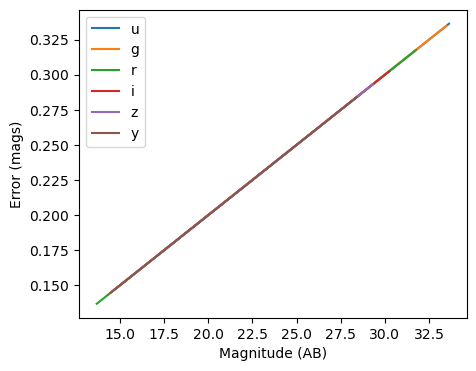

In [34]:
pipeline.get_stage("bad_error_model").plot()  # Compare this to the plot in the RAIL degrader notebook,
                                              # where we see very different errors!

And here, we grab a snippet of plotting code from the degrader demo notebook. 

As it is now, we can compare our DataStore's input data and its output data. 

What else would you want to show? And where would you fit the code in?

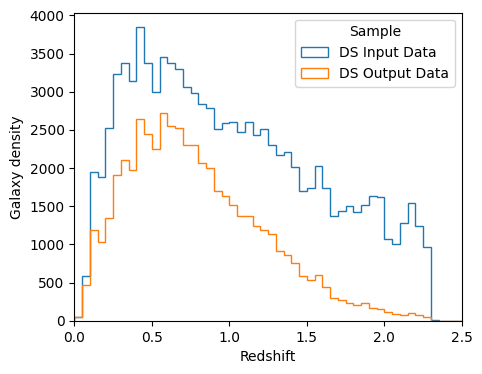

In [17]:
fig, ax = plt.subplots(figsize=(5, 4), dpi=100)

zmin = 0
zmax = 2.5

hist_settings = {
    "bins": 50,
    "range": (zmin, zmax),
    "density": False, # both versions are useful!
    "histtype": "step",
}

ax.hist(DS["input_data"]["redshift"], label="DS Input Data", **hist_settings)
ax.hist(DS["output_data"]["redshift"], label="DS Output Data", **hist_settings)
# One could extend this to plot the intermediate data, too...

ax.legend(title="Sample")
ax.set(xlim=(zmin, zmax), xlabel="Redshift", ylabel="Galaxy density")
plt.show()
